# <u>**Streaming Service Comparison**</u>

### **Objective:**
- Determine which streaming platform hosts the majority of content I enjoy so that I can pare down the services to which I subscribe. 

### **Data Sources:**
- [Netflix via Kaggle.com](https://www.kaggle.com/datasets/octopusteam/full-netflix-dataset)
- [Hulu via Kaggle.com](https://www.kaggle.com/datasets/octopusteam/full-hulu-dataset)
- [Prime via Kaggle.com](https://www.kaggle.com/datasets/octopusteam/full-amazon-prime-dataset/data)
- [AppleTV via Kaggle.com](https://www.kaggle.com/datasets/octopusteam/full-apple-tv-dataset)
- [Streaming Service Pricing](https://github.com/rkynhoff/Streaming_Service_Comparisons/blob/main/Data/Streaming_Services_Pricing_Histories.csv)
    - Created manually using  

## **Data Collection & Loading**

### **Import Pandas, Numpy, Matplotlib, Wordcloud, and PIL**

In [1]:
import glob
import pandas as pd
import os
import numpy as np
import pyspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sn
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image

### **Data Load**

In [2]:
# Load in each file separately. 
apple = pd.read_csv("Data/AppleTV.csv")
hulu = pd.read_csv("Data/Hulu.csv")
netflix = pd.read_csv("Data/Netflix.csv")
prime = pd.read_csv("Data/Prime.csv")
prices = pd.read_csv("Data/Streaming_Services_Pricing_Histories.csv")


### **Preliminary Data Exploration**

In [61]:
display(prices)

,Service_Name,Date,Price
0,AppleTV,Nov-19,4.99
1,AppleTV,Dec-19,4.99
2,AppleTV,Jan-20,4.99
3,AppleTV,Feb-20,4.99
4,AppleTV,Mar-20,4.99
...,...,...,...
251,Prime,Oct-24,14.99
252,Prime,Nov-24,14.99
253,Prime,Dec-24,14.99
254,Prime,Jan-25,14.99


In [62]:
prices.dtypes

Service_Name     object
Date             object
Price           float64
dtype: object

The prices df appears to have a date column in month/year. I will need to reformat that date field.

In [ ]:
# View the head of each service dataframe 
# Create a variable to include a list of all dataframes recently imported
services = [apple, hulu, netflix, prime]
# Display only the head of each dataframe separately
for s in services:
    display(s.head())

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,Four Rooms,movie,Comedy,1995.0,tt0113101,6.7,113546.0,NaN
1,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2354158.0,NaN
2,American Beauty,movie,Drama,1999.0,tt0169547,8.3,1241156.0,NaN
3,Citizen Kane,movie,"Drama, Mystery",1941.0,tt0033467,8.3,478085.0,NaN
4,Metropolis,movie,"Drama, Sci-Fi",1927.0,tt0017136,8.3,192628.0,NaN


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,8991.0,NaN
1,Shadows in Paradise,movie,"Comedy, Drama, Music",1986.0,tt0092149,7.5,7792.0,NaN
2,Finding Nemo,movie,"Adventure, Animation, Comedy",2003.0,tt0266543,8.2,1149529.0,NaN
3,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2354158.0,NaN
4,The Fifth Element,movie,"Action, Adventure, Sci-Fi",1997.0,tt0119116,7.6,522699.0,NaN


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,American Beauty,movie,Drama,1999.0,tt0169547,8.3,1241156.0,NaN
1,The Fifth Element,movie,"Action, Adventure, Sci-Fi",1997.0,tt0119116,7.6,522699.0,NaN
2,Kill Bill: Vol. 1,movie,"Action, Crime, Thriller",2003.0,tt0266697,8.2,1238778.0,NaN
3,Jarhead,movie,"Biography, Drama, War",2005.0,tt0418763,7.0,214024.0,NaN
4,Unforgiven,movie,"Drama, Western",1992.0,tt0105695,8.2,449594.0,NaN


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,8991.0,NaN
1,Four Rooms,movie,Comedy,1995.0,tt0113101,6.7,113546.0,NaN
2,Judgment Night,movie,"Action, Crime, Drama",1993.0,tt0107286,6.6,19686.0,NaN
3,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2354158.0,NaN
4,Citizen Kane,movie,"Drama, Mystery",1941.0,tt0033467,8.3,478085.0,NaN


,Service_Name,Date,Price
0,AppleTV,Nov-19,4.99
1,AppleTV,Dec-19,4.99
2,AppleTV,Jan-20,4.99
3,AppleTV,Feb-20,4.99
4,AppleTV,Mar-20,4.99


In [4]:
# Get a sum of the total row count from each dataframe
total_rows = len(apple) + len(hulu) + len(netflix) + len(prime)
print(f"The total row count is {total_rows} for all dataframes.")

The total row count is 119711 for all dataframes.


### **Initial Insights**
- There are a total of 119,711 among all raw dataframes
- Each dataframe contains the same column headings
- None of the dataframes contain a column for the source of the dataframe
- All numerical columns appear to be floats and don't need to be
    - Change ***releaseYear*** and ***imdbNumVotes*** to integers
- The majority of the titles displayed contain multiple genres in the ***genres*** column
- The ***imdbId*** columns appear to match 
    - *American Beauty* in the 1st and 3rd dataframe
    - *Forest Gump* in the 1st, 2nd and 4th dataframes
- Of all the rows displayed, none include ***availableCountries*** data
    - Further information proves that this data point is not prevelent throughout the four dataframes
- The prices df appears to have a date column in month/year.
    - I will need to reformat that date field.


### **Preliminary Data Manipulation**

In [6]:
# Add a column to each dataframe to identify the data source since individually they do not have an identifier. 
# This is to ensure the data is discernable after the merge when duplicate content is present
apple["Service_Name"] = "AppleTV"
apple["Price"] = 9.99
hulu["Service_Name"] = "Hulu"
hulu["Price"] = 9.99
netflix["Service_Name"] = "Netflix"
netflix["Price"] = 6.99
prime["Service_Name"] = "Prime"
prime["Price"] = 14.99


# Using a previously made variable, created a for loop to run through each dataframe and display only the first two rows of each
# This is to ensure the column names and values were added propertly
for s in services:
    display(s.head(2))

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries,Service_Name,Price
0,Four Rooms,movie,Comedy,1995.0,tt0113101,6.7,113546.0,NaN,AppleTV,9.99
1,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2354158.0,NaN,AppleTV,9.99


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries,Service_Name,Price
0,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,8991.0,NaN,Hulu,9.99
1,Shadows in Paradise,movie,"Comedy, Drama, Music",1986.0,tt0092149,7.5,7792.0,NaN,Hulu,9.99


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries,Service_Name,Price
0,American Beauty,movie,Drama,1999.0,tt0169547,8.3,1241156.0,NaN,Netflix,6.99
1,The Fifth Element,movie,"Action, Adventure, Sci-Fi",1997.0,tt0119116,7.6,522699.0,NaN,Netflix,6.99


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries,Service_Name,Price
0,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,8991.0,NaN,Prime,14.99
1,Four Rooms,movie,Comedy,1995.0,tt0113101,6.7,113546.0,NaN,Prime,14.99


,Service_Name,Date,Price
0,AppleTV,Nov-19,4.99
1,AppleTV,Dec-19,4.99


### **Data Merge**

In [7]:
# Merge the dataframes together into one by appending them to the end of each other since they are all using the same column names
streaming_v1 = pd.concat([apple, hulu, netflix, prime], axis = 0)

# Based on above initial review, check to ensure there are a total of 119,711 rows in the new dataframe
streaming_v1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119711 entries, 0 to 70293
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   title               116151 non-null  object 
 1   type                119711 non-null  object 
 2   genres              116226 non-null  object 
 3   releaseYear         119419 non-null  float64
 4   imdbId              109192 non-null  object 
 5   imdbAverageRating   105942 non-null  float64
 6   imdbNumVotes        105942 non-null  float64
 7   availableCountries  651 non-null     object 
 8   Service_Name        119711 non-null  object 
 9   Price               119711 non-null  float64
dtypes: float64(4), object(6)
memory usage: 10.0+ MB


### **Data Cleaning & Preparation**

In [8]:
# Drop the availableCountries column given that less than 1% (0.0054%) of entries utilize this data element
streaming_v1.drop("availableCountries", axis = 1, inplace=True)

# Display only the columns to ensure the dropped column is gone
streaming_v1.columns

Index(['title', 'type', 'genres', 'releaseYear', 'imdbId', 'imdbAverageRating',
       'imdbNumVotes', 'Service_Name', 'Price'],
      dtype='object')

In [9]:
# Rename the columns 
streaming_v1.rename(columns={"title":"Title","type":"Content_Type","genres":"Combined_Genres","releaseYear":"Release_Year","imdbId":"IMDb_ID","imdbAverageRating":"IMDb_Avg_Rating","imdbNumVotes":"IMDb_Votes_Count"},inplace = True)
streaming_v1.columns


Index(['Title', 'Content_Type', 'Combined_Genres', 'Release_Year', 'IMDb_ID',
       'IMDb_Avg_Rating', 'IMDb_Votes_Count', 'Service_Name', 'Price'],
      dtype='object')

In [10]:
# Change Release_Year, IMDb_Votes_Counts from floats to integers 
streaming_v1[["Release_Year","IMDb_Votes_Count"]] = streaming_v1[["Release_Year","IMDb_Votes_Count"]].apply(np.int64)
# Change Service_Name & Combined_Genres to string
streaming_v1[["Service_Name","Combined_Genres"]] == streaming_v1[["Service_Name","Combined_Genres"]].astype(str)

# Display only the data types to ensure the data types were changed
streaming_v1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119711 entries, 0 to 70293
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Title             116151 non-null  object 
 1   Content_Type      119711 non-null  object 
 2   Combined_Genres   116226 non-null  object 
 3   Release_Year      119711 non-null  int64  
 4   IMDb_ID           109192 non-null  object 
 5   IMDb_Avg_Rating   105942 non-null  float64
 6   IMDb_Votes_Count  119711 non-null  int64  
 7   Service_Name      119711 non-null  object 
 8   Price             119711 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 9.1+ MB


c:\Users\rkynhoff\OneDrive - University of Rochester\Documents\CodeLouisville\Streaming_Service_Comparisons\venv\Lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


In [11]:
# Determine how many titles contain null values
print("There are",streaming_v1["Title"].isna().sum(),"rows with null values in the Title column.")

There are 3560 rows with null values in the Title column.


In [12]:
# Drop the rows containing null values in the Title column
streaming_v1 = streaming_v1.dropna(subset=["Title"])

# Ensure duplicate rows were dropped
streaming_v1.info()

# Can see in the results that the total entries went from 119,711 to 116,151, a drop of 3,560 rows


<class 'pandas.core.frame.DataFrame'>
Index: 116151 entries, 0 to 70293
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Title             116151 non-null  object 
 1   Content_Type      116151 non-null  object 
 2   Combined_Genres   113936 non-null  object 
 3   Release_Year      116151 non-null  int64  
 4   IMDb_ID           109192 non-null  object 
 5   IMDb_Avg_Rating   105942 non-null  float64
 6   IMDb_Votes_Count  116151 non-null  int64  
 7   Service_Name      116151 non-null  object 
 8   Price             116151 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 8.9+ MB


In [13]:
# Determine how many duplicated rows exist
print("There are", streaming_v1.duplicated().sum(),"duplicated rows.")

There are 8 duplicated rows.


In [14]:
# Taking a look at the duplicated rows since there are so few & sort by title alphabetically with the default ascending
streaming_v1[streaming_v1.duplicated(keep=False)].sort_values("Title")

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Price
3486,A Personal Journey with Martin Scorsese Throug...,movie,"Biography, Documentary, History",1995,tt0112120,8.5,5201,AppleTV,9.99
13979,A Personal Journey with Martin Scorsese Throug...,movie,"Biography, Documentary, History",1995,tt0112120,8.5,5201,AppleTV,9.99
36061,Belle,movie,"Fantasy, Horror",2023,tt12373754,5.4,169,Prime,14.99
45434,Belle,movie,"Fantasy, Horror",2023,tt12373754,5.4,169,Prime,14.99
25222,Burn,movie,NaN,2014,NaN,NaN,-9223372036854775808,Prime,14.99
42998,Burn,movie,NaN,2014,NaN,NaN,-9223372036854775808,Prime,14.99
50643,Flower Boy,movie,NaN,2021,NaN,NaN,-9223372036854775808,Prime,14.99
51439,Flower Boy,movie,NaN,2021,NaN,NaN,-9223372036854775808,Prime,14.99
7245,Scorned: Love Kills,tv,"Crime, Documentary",2012,tt2287041,6.9,304,Hulu,9.99
7246,Scorned: Love Kills,tv,"Crime, Documentary",2012,tt2287041,6.9,304,Hulu,9.99


In [15]:
# Since the rows do appear to be fully dupliated, I will drop the duplicate rows here
streaming_v2 = streaming_v1.drop_duplicates()

# Reset the index
streaming_v2 = streaming_v2.reset_index(drop=True)

# View total of entires, which should equal 116143 (116151  - 8)
streaming_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116143 entries, 0 to 116142
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Title             116143 non-null  object 
 1   Content_Type      116143 non-null  object 
 2   Combined_Genres   113930 non-null  object 
 3   Release_Year      116143 non-null  int64  
 4   IMDb_ID           109187 non-null  object 
 5   IMDb_Avg_Rating   105937 non-null  float64
 6   IMDb_Votes_Count  116143 non-null  int64  
 7   Service_Name      116143 non-null  object 
 8   Price             116143 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 8.0+ MB


In [16]:
# Determine how man rows include null values for Combined_Genres
print("There are",streaming_v1["Combined_Genres"].isna().sum(),"rows with null values in the Combined_Genres column.")

There are 2215 rows with null values in the Combined_Genres column.


In [17]:
# View the rows with null values for Combined_Genres
# May need to address this later
streaming_v1.loc[streaming_v1["Combined_Genres"].isnull()]

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Price
2008,Anthappuram,movie,NaN,1980,tt0315778,5.6,7,AppleTV,9.99
3011,Siste trikk,movie,NaN,2024,NaN,NaN,-9223372036854775808,AppleTV,9.99
3082,Breathe without Water,movie,NaN,2024,NaN,NaN,-9223372036854775808,AppleTV,9.99
3088,El Arte De La Guerra,movie,NaN,2024,NaN,NaN,-9223372036854775808,AppleTV,9.99
3499,Atze Schröder - Revolution,movie,NaN,2010,NaN,NaN,-9223372036854775808,AppleTV,9.99
...,...,...,...,...,...,...,...,...,...
68120,Shea-suru ra! Instanto râmen arenji bu hajimem...,tv,NaN,2022,tt19408810,NaN,-9223372036854775808,Prime,14.99
68697,Secrets of the Exhibit,tv,NaN,2015,tt14546892,NaN,-9223372036854775808,Prime,14.99
68964,Hee!Hee!Hoo!,tv,NaN,2023,tt27010738,NaN,-9223372036854775808,Prime,14.99
69551,Kusuburi onna to sundome onna,tv,NaN,2023,tt29471798,NaN,-9223372036854775808,Prime,14.99


In [18]:
# Now that duplicated rows are gone, I want to see if there might be duplicated content baesd on IMDb_ID, Release_Year, Title, Content_Type, and Service Name
streaming_v2[streaming_v2.duplicated(subset = ["IMDb_ID","Title","Release_Year","Content_Type","Service_Name"], keep = False)].sort_values(by=["Title","Service_Name","Combined_Genres"], ascending=[True,True,True])

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Price
38236,Amr's in Trouble,movie,"Romance, Comedy",2019,NaN,NaN,-9223372036854775808,Netflix,6.99
41702,Amr's in Trouble,movie,NaN,2019,NaN,NaN,-9223372036854775808,Netflix,6.99
93066,Aurora,movie,Animation,2019,NaN,NaN,-9223372036854775808,Prime,14.99
92157,Aurora,movie,Horror,2019,NaN,NaN,-9223372036854775808,Prime,14.99
13328,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,AppleTV,9.99
13557,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,AppleTV,9.99
42322,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Netflix,6.99
42627,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Netflix,6.99
105044,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Prime,14.99
106211,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Prime,14.99


In [19]:
# Based on the output above, I can see there is duplicated content and rows where genres could be combined into one row for each Service_Name

# Remove the duplicated rows that have a null value in the Combined_Genres column by index number
streaming_v3 = streaming_v2.drop([41702,12177,37721,89252,108129,108076,40887,102086,107404])
# Reset index
streaming_v3 = streaming_v3.reset_index(drop=True)
# Double check
streaming_v3[streaming_v3["Title"] == "The Final Ride"]


,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Price
87483,The Final Ride,movie,"Comedy, Horror",2019,tt9869668,5.4,83,Prime,14.99
103850,The Final Ride,movie,"Crime, Action",2021,NaN,NaN,-9223372036854775808,Prime,14.99


In [20]:
# Redisplay the duplicated content baesd on IMDb_ID, Release_Year, Title, Content_Type, and Service Name

grouped_dupes = streaming_v3[streaming_v3.duplicated(subset = ["IMDb_ID","Title","Release_Year","Content_Type","Service_Name"], keep = False)].sort_values(by=["Title","Service_Name","Combined_Genres"], ascending=[True,True,True])
grouped_dupes

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Price
93061,Aurora,movie,Animation,2019,NaN,NaN,-9223372036854775808,Prime,14.99
92152,Aurora,movie,Horror,2019,NaN,NaN,-9223372036854775808,Prime,14.99
13327,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,AppleTV,9.99
13556,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,AppleTV,9.99
42318,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Netflix,6.99
42623,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Netflix,6.99
105038,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Prime,14.99
106205,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Prime,14.99
106324,Fences,movie,"Comedy, Drama",2023,NaN,NaN,-9223372036854775808,Prime,14.99
103994,Fences,movie,Documentary,2023,NaN,NaN,-9223372036854775808,Prime,14.99


In [21]:
# See AI_Notes.docx for more information on how this code block came about
# Initialize an empty dictionary in which to store concatenated genres
concatenated_genres = {}

# Iterate over each row in the grouped_dupes dataframe
for index, row in grouped_dupes.iterrows():
    # Createa a unique key for each row in the grouped_dupes dataframe by combining certain columns
    key = (row["Title"], row["Content_Type"],row["Release_Year"], row["IMDb_ID"], row["IMDb_Votes_Count"], row["Service_Name"])
    # Checks if the key exists in the concatenated_genres dictionary & if so, append the new genres from the currnt row to the existing list of genres in the dictionary with a comma and space after each
    if key in concatenated_genres:
        concatenated_genres[key] += row["Combined_Genres"] + ', '
    # If the key doesn't exist in the dictionary, create a new entry in the dictionary with the combined genres from the current row, with a comma and a space
    else:
        concatenated_genres[key] = row["Combined_Genres"] + ', '

# Iniitialize a list to 
result_data = []
# Iterate over each key-value pair in the concatenated_genres dictionary
for key, genres in concatenated_genres.items():
    # Append a new list to the result_data list which contains the key values and the genres with the trailing comma and space removed
    result_data.append([key[0], key[1], genres[:-2], key[2], key[3], key[4], key[5]])

# Create a new dataframe from the result_data list with specified column names
result_df = pd.DataFrame(result_data, columns = ["Title","Content_Type","Combined_Genres","Release_Year","IMDb_ID","IMDb_Votes_Count","Service_Name"])
# Create a new column in the new dataframe and assign the value of "none"
# This was done because each time I attempted to add the IMDb_Avg_Rating column to the key list above, the code would fail because it is an integer column in the original dataframe
result_df["IMDb_Avg_Rating"] = "None"
# Define a list of columns in the order in which I want them in the new dataframe
column_titles = ["Title","Content_Type","Combined_Genres","Release_Year","IMDb_ID","IMDb_Avg_Rating","IMDb_Votes_Count","Service_Name"]
# reorder the columns in the new dataframe to match the specified order in the above code line
result_df = result_df.reindex(columns=column_titles)
# Display the new dataframe
display(result_df)

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
0,Aurora,movie,"Animation, Horror",2019,NaN,None,-9223372036854775808,Prime
1,De olhos abertos,movie,"Animation, Drama, War",2023,NaN,None,-9223372036854775808,AppleTV
2,De olhos abertos,movie,"Animation, Drama, War",2023,NaN,None,-9223372036854775808,Netflix
3,De olhos abertos,movie,"Animation, Drama, War",2023,NaN,None,-9223372036854775808,Prime
4,Fences,movie,"Comedy, Drama, Documentary",2023,NaN,None,-9223372036854775808,Prime
5,Imago,movie,"Drama, Thriller, Horror",2024,NaN,None,-9223372036854775808,Prime
6,Leonardo: The Man Who Saved Science,movie,"Documentary, History, Documentary, History, TV...",2017,NaN,None,-9223372036854775808,Prime
7,Stealing Chaplin,movie,"Comedy, Drama, Comedy, History",2024,NaN,None,-9223372036854775808,Prime
8,When life gives you lemons,movie,"Animation, Music",2024,NaN,None,-9223372036854775808,Prime


In [22]:
# Append the newly created dataframe to the previous dataframe
streaming_v4 = pd.concat([streaming_v3,result_df], axis = 0)

# Reset the indeces
streaming_v4.reset_index(drop=True) 

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Price
0,Four Rooms,movie,Comedy,1995,tt0113101,6.7,113546,AppleTV,9.99
1,Forrest Gump,movie,"Drama, Romance",1994,tt0109830,8.8,2354158,AppleTV,9.99
2,American Beauty,movie,Drama,1999,tt0169547,8.3,1241156,AppleTV,9.99
3,Citizen Kane,movie,"Drama, Mystery",1941,tt0033467,8.3,478085,AppleTV,9.99
4,Metropolis,movie,"Drama, Sci-Fi",1927,tt0017136,8.3,192628,AppleTV,9.99
...,...,...,...,...,...,...,...,...,...
116138,Fences,movie,"Comedy, Drama, Documentary",2023,NaN,None,-9223372036854775808,Prime,NaN
116139,Imago,movie,"Drama, Thriller, Horror",2024,NaN,None,-9223372036854775808,Prime,NaN
116140,Leonardo: The Man Who Saved Science,movie,"Documentary, History, Documentary, History, TV...",2017,NaN,None,-9223372036854775808,Prime,NaN
116141,Stealing Chaplin,movie,"Comedy, Drama, Comedy, History",2024,NaN,None,-9223372036854775808,Prime,NaN


In [23]:
# Check to ensure that one of the titles with a duplicate row matching title, content_type, release_year, and service_name, but with a null value is Genres is present with the correct combined genres
streaming_v4[streaming_v4["Title"] == "The Final Ride"]

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Price
87483,The Final Ride,movie,"Comedy, Horror",2019,tt9869668,5.4,83,Prime,14.99
103850,The Final Ride,movie,"Crime, Action",2021,NaN,NaN,-9223372036854775808,Prime,14.99


In [24]:
display(streaming_v4[streaming_v4["Title"] == "Aurora"])
display(streaming_v4[streaming_v4["Title"] == "De olhos abertos"]) 
display(streaming_v4[streaming_v4["Title"] == "Fences"])
display(streaming_v4[streaming_v4["Title"] == "Imago"])
display(streaming_v4[streaming_v4["Title"] == "Fences"])
display(streaming_v4[streaming_v4["Title"] == "Leonardo: The Man Who Saved Science"])
display(streaming_v4[streaming_v4["Title"] == "Stealing Chaplin"])
display(streaming_v4[streaming_v4["Title"] == "When life gives you lemons"])

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Price
10284,Aurora,movie,Drama,2017,NaN,NaN,-9223372036854775808,AppleTV,9.99
36433,Aurora,movie,"Horror, Thriller",2018,tt8821182,4.4,729,Netflix,6.99
86916,Aurora,movie,"Comedy, Drama, Romance",2019,tt8553606,6.7,1893,Prime,14.99
90079,Aurora,movie,Drama,2017,NaN,NaN,-9223372036854775808,Prime,14.99
92152,Aurora,movie,Horror,2019,NaN,NaN,-9223372036854775808,Prime,14.99
93061,Aurora,movie,Animation,2019,NaN,NaN,-9223372036854775808,Prime,14.99
0,Aurora,movie,"Animation, Horror",2019,NaN,None,-9223372036854775808,Prime,NaN


,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Price
13327,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,AppleTV,9.99
13556,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,AppleTV,9.99
42318,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Netflix,6.99
42623,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Netflix,6.99
105038,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Prime,14.99
106205,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Prime,14.99
1,De olhos abertos,movie,"Animation, Drama, War",2023,NaN,None,-9223372036854775808,AppleTV,NaN
2,De olhos abertos,movie,"Animation, Drama, War",2023,NaN,None,-9223372036854775808,Netflix,NaN
3,De olhos abertos,movie,"Animation, Drama, War",2023,NaN,None,-9223372036854775808,Prime,NaN


,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Price
7898,Fences,movie,Drama,2016,tt2671706,7.2,121120,AppleTV,9.99
13577,Fences,movie,"Comedy, Drama",2023,NaN,NaN,-9223372036854775808,AppleTV,9.99
42659,Fences,movie,"Comedy, Drama",2023,NaN,NaN,-9223372036854775808,Netflix,6.99
77214,Fences,movie,Drama,2016,tt2671706,7.2,121120,Prime,14.99
103994,Fences,movie,Documentary,2023,NaN,NaN,-9223372036854775808,Prime,14.99
106324,Fences,movie,"Comedy, Drama",2023,NaN,NaN,-9223372036854775808,Prime,14.99
4,Fences,movie,"Comedy, Drama, Documentary",2023,NaN,None,-9223372036854775808,Prime,NaN


,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Price
105665,Imago,movie,"Drama, Thriller",2024,NaN,NaN,-9223372036854775808,Prime,14.99
108035,Imago,movie,Horror,2024,NaN,NaN,-9223372036854775808,Prime,14.99
5,Imago,movie,"Drama, Thriller, Horror",2024,NaN,None,-9223372036854775808,Prime,NaN


,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Price
7898,Fences,movie,Drama,2016,tt2671706,7.2,121120,AppleTV,9.99
13577,Fences,movie,"Comedy, Drama",2023,NaN,NaN,-9223372036854775808,AppleTV,9.99
42659,Fences,movie,"Comedy, Drama",2023,NaN,NaN,-9223372036854775808,Netflix,6.99
77214,Fences,movie,Drama,2016,tt2671706,7.2,121120,Prime,14.99
103994,Fences,movie,Documentary,2023,NaN,NaN,-9223372036854775808,Prime,14.99
106324,Fences,movie,"Comedy, Drama",2023,NaN,NaN,-9223372036854775808,Prime,14.99
4,Fences,movie,"Comedy, Drama, Documentary",2023,NaN,None,-9223372036854775808,Prime,NaN


,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Price
82038,Leonardo: The Man Who Saved Science,movie,"Documentary, History, War",2017,tt6764348,7.0,72,Prime,14.99
93553,Leonardo: The Man Who Saved Science,movie,"Documentary, History, TV Movie",2017,NaN,NaN,-9223372036854775808,Prime,14.99
96736,Leonardo: The Man Who Saved Science,movie,"Documentary, History",2017,NaN,NaN,-9223372036854775808,Prime,14.99
6,Leonardo: The Man Who Saved Science,movie,"Documentary, History, Documentary, History, TV...",2017,NaN,None,-9223372036854775808,Prime,NaN


,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Price
94012,Stealing Chaplin,movie,Drama,2020,tt10205046,4.8,148,Prime,14.99
107192,Stealing Chaplin,movie,"Drama, Comedy, History",2024,NaN,NaN,-9223372036854775808,Prime,14.99
107203,Stealing Chaplin,movie,Comedy,2024,NaN,NaN,-9223372036854775808,Prime,14.99
7,Stealing Chaplin,movie,"Comedy, Drama, Comedy, History",2024,NaN,None,-9223372036854775808,Prime,NaN


,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Price
56996,When life gives you lemons,movie,Music,2024,NaN,NaN,-9223372036854775808,Prime,14.99
107581,When life gives you lemons,movie,Animation,2024,NaN,NaN,-9223372036854775808,Prime,14.99
8,When life gives you lemons,movie,"Animation, Music",2024,NaN,None,-9223372036854775808,Prime,NaN


In [25]:
# streaming_v2[streaming_v2.duplicated(subset = ["IMDb_ID","Title","Release_Year","Content_Type","Service_Name"], keep = False)].sort_values(by=["Title","Service_Name","Combined_Genres"], ascending=[True,True,True])
streaming_v5 = streaming_v4.drop([92152,93061,13327,13556,42318,42623,105038,106205,103994,106324,105665,108035,93553,96736,107192,107203,56996,107581])

In [26]:
# Checking for the subset duplicates again
streaming_v5[streaming_v5.duplicated(subset = ["Title","Content_Type","Combined_Genres","Release_Year","IMDb_ID","Service_Name"], keep = False)].sort_values(by=["Title","Combined_Genres","Service_Name"], ascending=[True,True,True]).sort_index()

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Price


In [27]:
# Checking a specific title to ensure of dropped rows
display(streaming_v5[streaming_v5["Title"] == "Aurora"])

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Price
10284,Aurora,movie,Drama,2017,NaN,NaN,-9223372036854775808,AppleTV,9.99
36433,Aurora,movie,"Horror, Thriller",2018,tt8821182,4.4,729,Netflix,6.99
86916,Aurora,movie,"Comedy, Drama, Romance",2019,tt8553606,6.7,1893,Prime,14.99
90079,Aurora,movie,Drama,2017,NaN,NaN,-9223372036854775808,Prime,14.99
0,Aurora,movie,"Animation, Horror",2019,NaN,None,-9223372036854775808,Prime,NaN


In [28]:
streaming_v5.dtypes

Title                object
Content_Type         object
Combined_Genres      object
Release_Year          int64
IMDb_ID              object
IMDb_Avg_Rating      object
IMDb_Votes_Count      int64
Service_Name         object
Price               float64
dtype: object

In [29]:
# An attempt to remove the duplicated Genre values in the Combined_Genres column prior to splitting the values into separate columns
# def remove_duped_combined_genres(Combined_Genres):
#     genres = Combined_Genres.str.split()
#     unique_comb_genres = list(dict.fromkeys(genres))
#     return ' '.join(unique_comb_genres)

# streaming_v5["Combined_Genres"] = streaming_v5["Combined_Genres"].apply(remove_duped_combined_genres)

In [30]:
# Second attempt to remove the duplicated Genre values in the Combined_Genres column prior to splitting the values into separate columns
# streaming_v5["Combined_Genres"] = streaming_v5["Combined_Genres"].apply(lambda x: ' '.join(set(x.split())))

In [31]:
# Still seeing the duplicated word "Comedy" in the COmbined_Genres column
display(streaming_v5[streaming_v5["Title"] == "Stealing Chaplin"])

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Price
94012,Stealing Chaplin,movie,Drama,2020,tt10205046,4.8,148,Prime,14.99
7,Stealing Chaplin,movie,"Comedy, Drama, Comedy, History",2024,NaN,None,-9223372036854775808,Prime,NaN


In [32]:
streaming_v5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116125 entries, 0 to 8
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Title             116125 non-null  object 
 1   Content_Type      116125 non-null  object 
 2   Combined_Genres   113921 non-null  object 
 3   Release_Year      116125 non-null  int64  
 4   IMDb_ID           109187 non-null  object 
 5   IMDb_Avg_Rating   105946 non-null  object 
 6   IMDb_Votes_Count  116125 non-null  int64  
 7   Service_Name      116125 non-null  object 
 8   Price             116116 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 8.9+ MB


In [33]:
#Obtain max number of elements in the Genres column
# streaming_v4["Combined_Genres"].str.split(", ",expand=True)


In [34]:
# Split the elements in the Genres column while creating new columns for the max number 
streaming_v5[["Genre_1","Genre_2","Genre_3","Genre_4","Genre_5","Genre_6","Genre_7"]] = streaming_v5["Combined_Genres"].str.split(',',expand=True)

streaming_v5.head(2)

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Price,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,Genre_6,Genre_7
0,Four Rooms,movie,Comedy,1995,tt0113101,6.7,113546,AppleTV,9.99,Comedy,None,None,None,None,None,None
1,Forrest Gump,movie,"Drama, Romance",1994,tt0109830,8.8,2354158,AppleTV,9.99,Drama,Romance,None,None,None,None,None


In [35]:
# Creating clean dataframe
streaming_clean = streaming_v5

In [36]:
# Create a final CSV file from the cleaned dataframe to use in Tableau
# Note this is commented out after the first run to create the file so the program doesn't fail

# streaming_clean.to_csv("Streaming_Clean_Final.csv", sep=",", index=False, header=True)

### **Begin Analysis**

In [37]:
streaming_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116125 entries, 0 to 8
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Title             116125 non-null  object 
 1   Content_Type      116125 non-null  object 
 2   Combined_Genres   113921 non-null  object 
 3   Release_Year      116125 non-null  int64  
 4   IMDb_ID           109187 non-null  object 
 5   IMDb_Avg_Rating   105946 non-null  object 
 6   IMDb_Votes_Count  116125 non-null  int64  
 7   Service_Name      116125 non-null  object 
 8   Price             116116 non-null  float64
 9   Genre_1           113921 non-null  object 
 10  Genre_2           75979 non-null   object 
 11  Genre_3           44387 non-null   object 
 12  Genre_4           117 non-null     object 
 13  Genre_5           27 non-null      object 
 14  Genre_6           3 non-null       object 
 15  Genre_7           1 non-null       object 
dtypes: float64(1), int64(2), objec

In [38]:
# Hex Codes for streaming services
# Apple: gray = #A3AAAE, blue = #009DDC
# Hulu: greeen = #1CE783, black = #001908
# Netflix: crimson = #E50914, black = #221F1F
# Prime: orange = #FF9900, blue = #05A0D1, dark blue: #232F3E

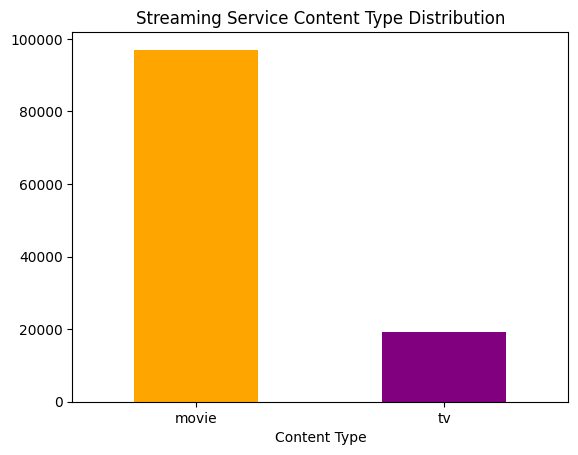

In [39]:
# Crate a bar graph to show distribution of content types from the Content_Type column
# Plot it with orange for "movies" and purple for "tv"
streaming_clean["Content_Type"].value_counts().plot(kind='bar',color=["orange","purple"])
# Add a plot title
plt.title("Streaming Service Content Type Distribution")
# Change the orientation of the x ticks
plt.xticks(rotation = 360)
# Relable the X axis
plt.xlabel("Content Type")
# Show the bar graph 
plt.show()


Content Type Analysis
- Among the four streaming services analyzed, the majority of content is steeped in movies over tv shows
- There appears to be nearly 5 times the amount of movies vs tv shows offered among all four platforms

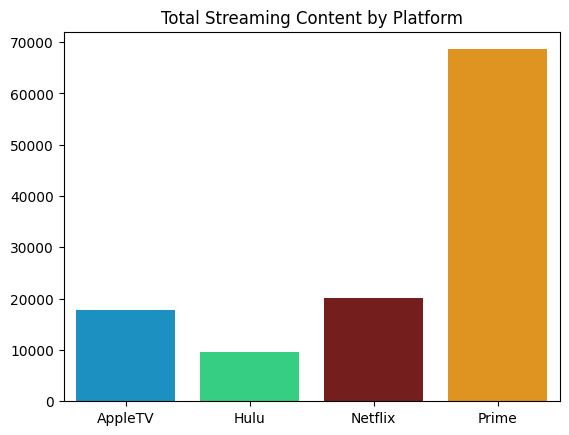

In [40]:
# Plotting which streaming platform contains the most content
chart = sn.countplot(streaming_clean, x = "Service_Name", hue = "Service_Name", palette = ["#009DDC","#1CE783","#831010","#FF9900"])
chart.set_ylabel("")
chart.set_xlabel("")
chart.set_title("Total Streaming Content by Platform")
plt.show()


In [41]:
# streaming_clean["Service_Name"].value_counts().plot(kind='bar',color=["#FF9900","#831010","#A3AAAE","#1CE783"])
# # Add a plot title
# plt.title("Total Streaming Content by Platform")
# # Change the orientation of the x ticks
# plt.xticks(rotation = 360)
# # Show the bar graph 
# plt.show()

Text(0.5, 0, 'Service Name')

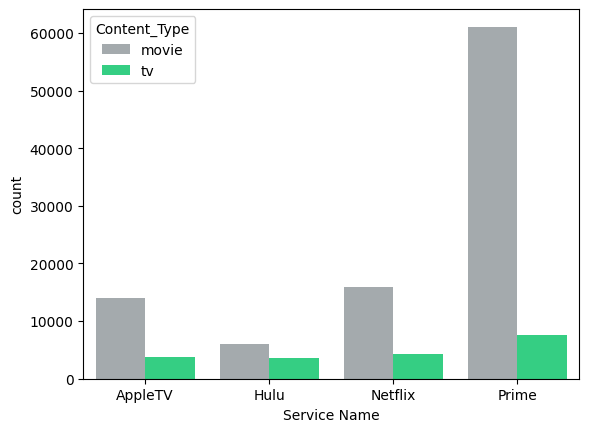

In [42]:
# Counts of the content type by streaming sesrvice

# Hex Codes for streaming services
# Apple: gray = #A3AAAE, blue = #009DDC
# Hulu: greeen = #1CE783, black = #001908
# Netflix: crimson = #D81F26, black = #221F1F
# Prime: orange = #FF9900, blue = #05A0D1, dark blue: #232F3E

# Define the colors for each content_type
# movie_colors = ["#A3AAAE", "#1CE783", "#D81F26", "#A3AAAE"]
# tv_colors = ["#009DDC", "#001908", "#221F1F", "#232F3E"]
sn.countplot(streaming_clean, x = "Service_Name", hue = "Content_Type", palette = ["#A3AAAE", "#1CE783"])
plt.xlabel("Service Name")



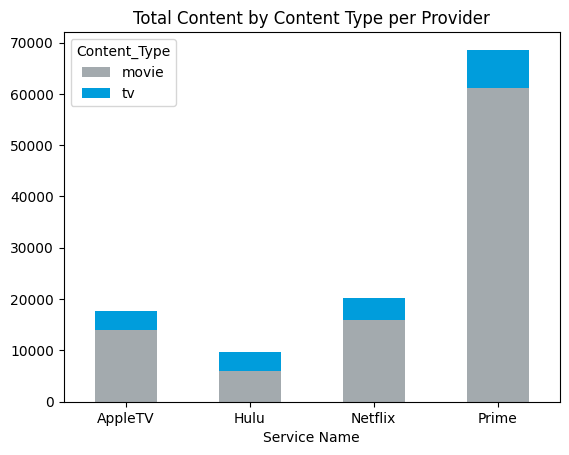

In [43]:
# Let's compare apples to apples and stack the content types to compare total content among the four service providers

# Group by Service_Name and count the number of each Content_Type
cont_type = streaming_clean.groupby("Service_Name")["Content_Type"].value_counts().unstack(fill_value = 0)

# Plot the result of the grouped data above as a stacked bar plot with specific coloring
cont_type.plot(kind =  "bar", stacked = True, color = ["#A3AAAE", "#009DDC"])
# Relable the x axis
plt.xlabel("Service Name")
# Reposition the x labels so they are horizontal with the x axis
plt.xticks(rotation = 360)
# Create a graph title
plt.title("Total Content by Content Type per Provider")
plt.show()

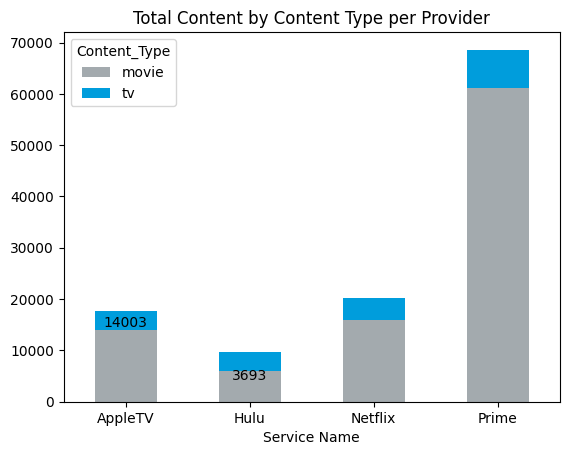

In [44]:
# Attempt at adding value_count labels 
# Group by Service_Name and count the number of each Content_Type
cont_type = streaming_clean.groupby(["Service_Name", "Content_Type"]).size().reset_index(name="count")

# Plot the result of the grouped data above as a stacked bar plot with specific coloring
cont_typepivot = cont_type.pivot_table(index="Service_Name", columns="Content_Type", values="count", fill_value=0)
cont_typepivot.plot(kind =  "bar", stacked = True, color = ["#A3AAAE", "#009DDC"])

# Relable the x axis
plt.xlabel("Service Name")
# Reposition the x labels so they are horizontal with the x axis
plt.xticks(rotation = 360)
# Create a chart title
plt.title("Total Content by Content Type per Provider")

# Get the height of the bars
bar_heights = cont_typepivot.iloc[0].values

# Get the x positions of the bars
bar_positions = range(len(cont_typepivot.columns))

# Create value count labels inside the bars on the graph
for i, height in enumerate(bar_heights):
    if height > 0:
        plt.text(bar_positions[i], height + 5, str(int(height)), ha='center', va='bottom')

# Show the plot
plt.show()

Content Type Analysis
- At first glance, the Prime content catalog appears to be nearly twice that of other providers
    - This is because much of the content within Prime is either available for rent or through a secondary subscription service

In [45]:
combined_null = streaming_clean["Combined_Genres"].isnull().sum()

print(f"There are {combined_null} null values in the Combined_Genres column.")

There are 2204 null values in the Combined_Genres column.


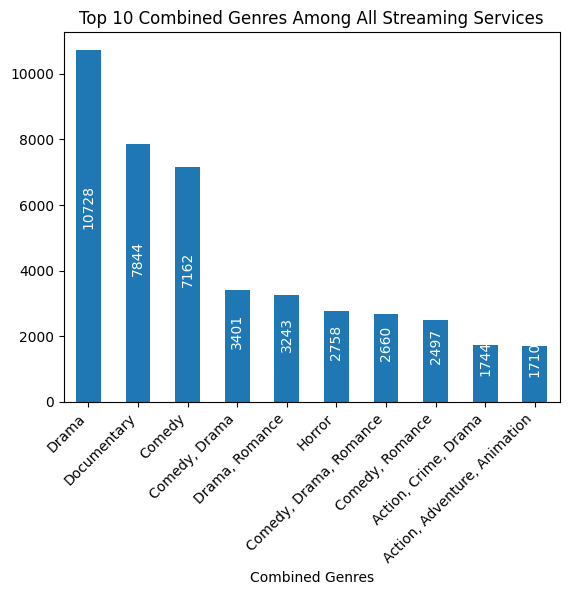

In [46]:
# Create a value count variable for the top 10 value cgenres in the Combined_Genres column and count them
genre_counts = streaming_clean["Combined_Genres"].value_counts().head(10)
# Plot the genres
genre_counts.plot.bar()

# Creating a loop to put the value count of each genre count into the middle of its respective bar vertically in white font
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width()/2, height/2, str(height), ha = "center", color = "white", rotation = 90)

# create a Combined Genres label on the x axis
plt.xlabel("Combined Genres")
# rotate x-labels to 45 degree angle with a right text orientation
plt.xticks(rotation = 45, ha = "right")
# create a graph title
plt.title("Top 10 Combined Genres Among All Streaming Services")
# Show the plot
plt.show()

Cobmined Genres Analysis
- Of the values in the Combined_Genres column, 2,204 are null. 
- The tope three values within the Combined_Genres column are actually individual genres comprising of # of the overall content among all service providers
- Within the top 5 genres, Drama was paired with Comedy # times and with Romance # times
- While horror is 6th in the list, it is also an individual genre 

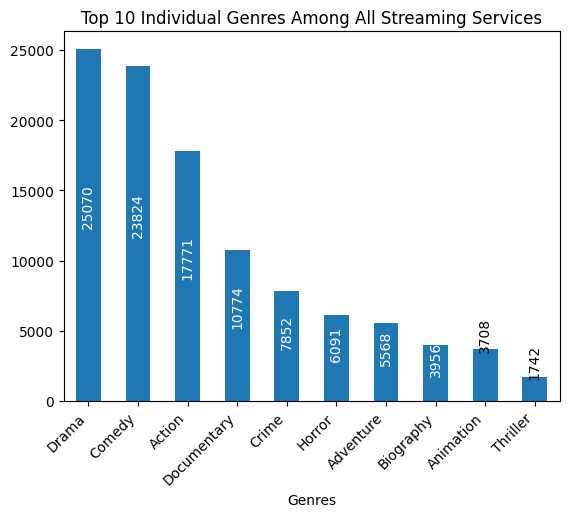

In [47]:
# Looking for the top 10 genres offered among the streaming services based on the first genre listed in the Combined_Genres column parsed into the Genre_1 column
# Create a value count variable for the top 10 value cgenres in the Combined_Genres column and count them
genre_counts = streaming_clean["Genre_1"].value_counts().head(10)
# Plot the genres
genre_counts.plot.bar()

# Creating a loop to put the value count of each genre count into the middle of its respective bar vertically in white font
for i, p in enumerate(plt.gca().patches):
    height = p.get_height()
    # For all bars but last two, show the label inside the bar with white font
    if height < 10: 
        plt.gca().text(p.get_x() + p.get_width()/2, height + 10, str(height), ha = "center", color = "black")
    elif i < len(plt.gca().patches) - 2:
        plt.gca().text(p.get_x() + p.get_width()/2, height/2, str(height), ha = "center", color = "white", rotation = 90)
    else: 
        # For the last two columns, put label above the bar in black font
        plt.gca().text(p.get_x() + p.get_width()/2, height + 10, str(height), ha = "center", color = "black", rotation = 90)

# create a Combined Genres label on the x axis
plt.xlabel("Genres")
# rotate x-labels to 45 degree angle with a right text orientation
plt.xticks(rotation = 45, ha = "right")
# create a graph title
plt.title("Top 10 Individual Genres Among All Streaming Services")
# Show the plot
plt.show()


The top 10 individual genres among all four streaming platforms are 
1. Drama
2. Comedy
3. Action
4. Documentary
5. Crime
6. Horor
7. Adventure
8. Biography
9. Animation
10. Thriller

Not surprisingly, Drama and Comedy make up the top two individual genre categories. Note that the Romance category hasn't made the top 10 of individual genres. 

In [48]:
# streaming_clean[["Genre_1","IMDb_Avg_Rating"]].value_counts().head(10).plot.bar(x = "Genre_1", y = "IMDb_Avg_Rating")

<function matplotlib.pyplot.show(close=None, block=None)>

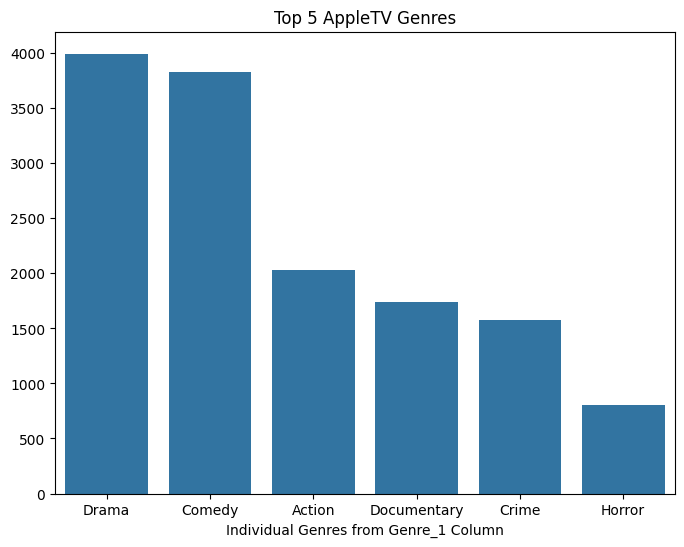

In [49]:
# Separate the AppleTV rows from the rest of the df
apple_tv = streaming_clean[streaming_clean["Service_Name"] == "AppleTV"] 
# Group the Genre_1 column and get the total counts for each genre
apple_tv_genres = apple_tv.groupby("Genre_1")["Genre_1"].count().reset_index(name = "Count")
# Ascertain the top 5 genres
top_apple_tv_genres = apple_tv_genres.sort_values("Count", ascending = False).head(6)

plt.figure(figsize = (8, 6))
sn.barplot(x = top_apple_tv_genres["Genre_1"], y = top_apple_tv_genres["Count"])
plt.xlabel("Individual Genres from Genre_1 Column")
plt.ylabel(None)
plt.title("Top 5 AppleTV Genres")

plt.show


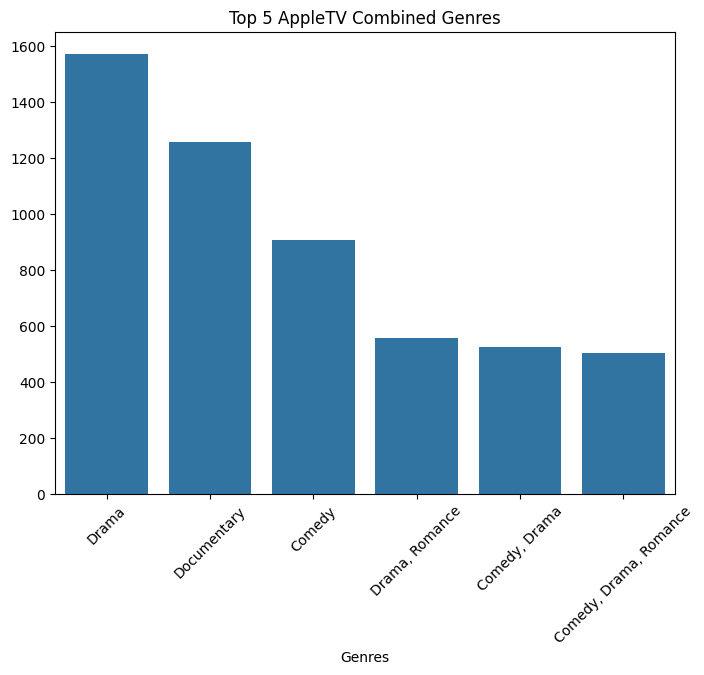

In [50]:
# Group the Genre_1 column and get the total counts for each genre
apple_tv_genres = apple_tv.groupby("Combined_Genres")["Combined_Genres"].count().reset_index(name = "Count")
# Ascertain the top 5 genres
top_apple_tv_genres = apple_tv_genres.sort_values("Count", ascending = False).head(6)

plt.figure(figsize = (8, 6))
sn.barplot(x = top_apple_tv_genres["Combined_Genres"], y = top_apple_tv_genres["Count"])
plt.xlabel("Genres")
plt.ylabel(None)
plt.xticks(rotation = 45)
plt.title("Top 5 AppleTV Combined Genres")

plt.show()

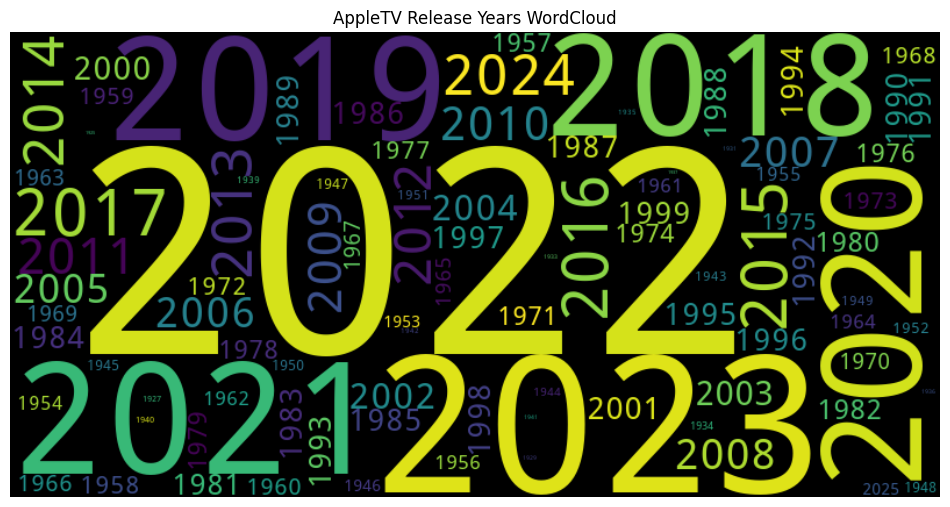

In [51]:
# Create variable with value counts of each release year
release_yr_cnts = apple_tv["Release_Year"].value_counts()

# Convert the index of the Release Years from integers to strings because WordCloud requires strings inputs
release_yr_cnts.index = release_yr_cnts.index.map(str)

# Create the WordCloud specifying 
apple_tv_wordcloud = WordCloud(width = 800, height = 400, background_color = "black").generate_from_frequencies(release_yr_cnts)

# Setting figure size in inches
plt.figure(figsize = (12, 8))
# Show the created WordCloud with a bilinear interpolation, which is used to estimate the value of pixels used to generate the image
plt.imshow(apple_tv_wordcloud, interpolation = "bilinear")
# Do not display axes
plt.axis("off")
# Create a title for the WordCloud
plt.title("AppleTV Release Years WordCloud")
# Show the plot
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

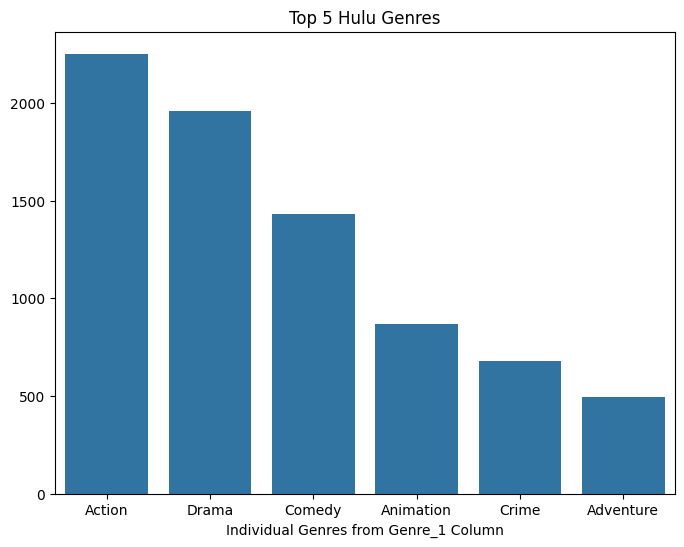

In [52]:
# Separate the Hulu rows from the rest of the df
hulu_tv = streaming_clean[streaming_clean["Service_Name"] == "Hulu"] 
# Group the Genre_1 column and get the total counts for each genre
hulu_tv_genres = hulu_tv.groupby("Genre_1")["Genre_1"].count().reset_index(name = "Count")
# Ascertain the top 5 genres
top_hulu_tv_genres = hulu_tv_genres.sort_values("Count", ascending = False).head(6)

plt.figure(figsize = (8, 6))
sn.barplot(x = top_hulu_tv_genres["Genre_1"], y = top_hulu_tv_genres["Count"])
plt.xlabel("Individual Genres from Genre_1 Column")
plt.ylabel(None)
plt.title("Top 5 Hulu Genres")

plt.show


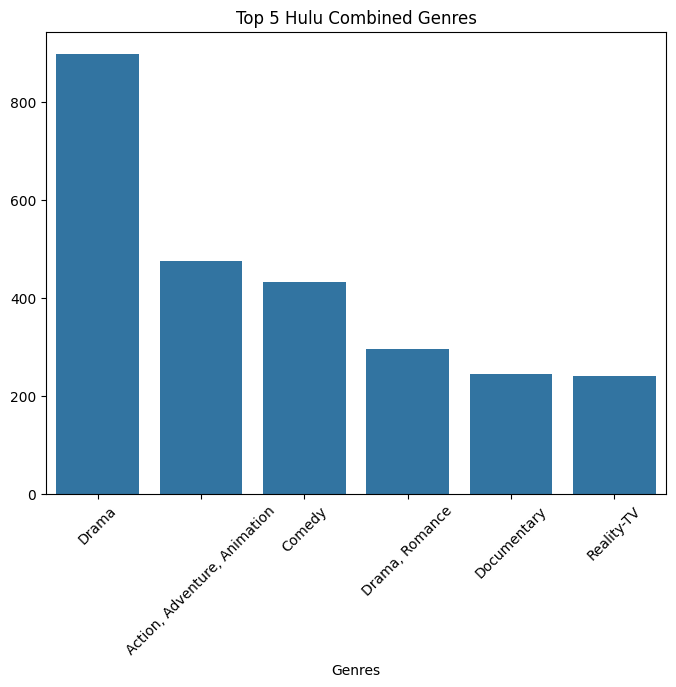

In [53]:
# Group the Genre_1 column and get the total counts for each genre
hulu_tv_genres = hulu_tv.groupby("Combined_Genres")["Combined_Genres"].count().reset_index(name = "Count")
# Ascertain the top 5 genres
top_hulu_tv_genres = hulu_tv_genres.sort_values("Count", ascending = False).head(6)

plt.figure(figsize = (8, 6))
sn.barplot(x = top_hulu_tv_genres["Combined_Genres"], y = top_hulu_tv_genres["Count"])
plt.xlabel("Genres")
plt.ylabel(None)
plt.xticks(rotation = 45)
plt.title("Top 5 Hulu Combined Genres")

plt.show()

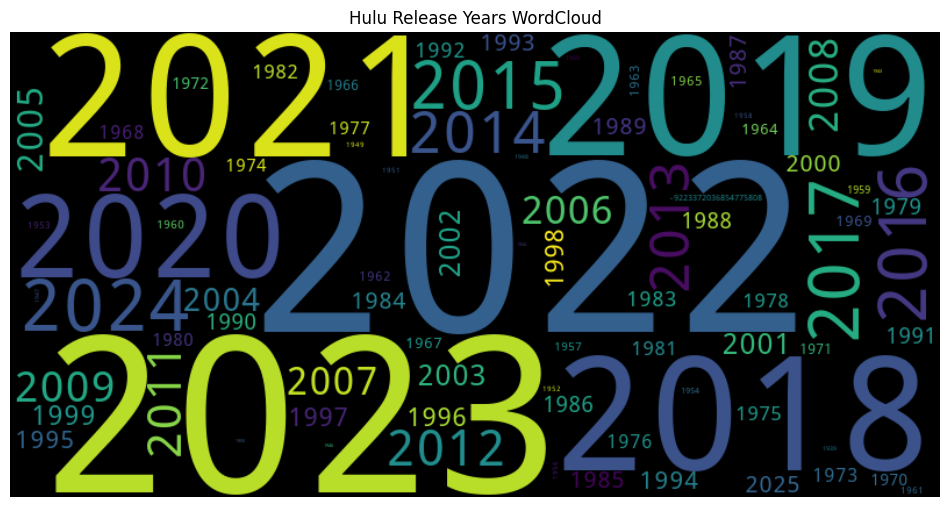

In [54]:
# Create variable with value counts of each release year
release_yr_cnts = hulu_tv["Release_Year"].value_counts()

# Convert the index of the Release Years from integers to strings because WordCloud requires strings inputs
release_yr_cnts.index = release_yr_cnts.index.map(str)

# Create the WordCloud specifying 
hulu_tv_wordcloud = WordCloud(width = 800, height = 400, background_color = "black").generate_from_frequencies(release_yr_cnts)

# Setting figure size in inches
plt.figure(figsize = (12, 8))
# Show the created WordCloud with a bilinear interpolation, which is used to estimate the value of pixels used to generate the image
plt.imshow(hulu_tv_wordcloud, interpolation = "bilinear")
# Do not display axes
plt.axis("off")
# Create a title for the WordCloud
plt.title("Hulu Release Years WordCloud")
# Show the plot
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

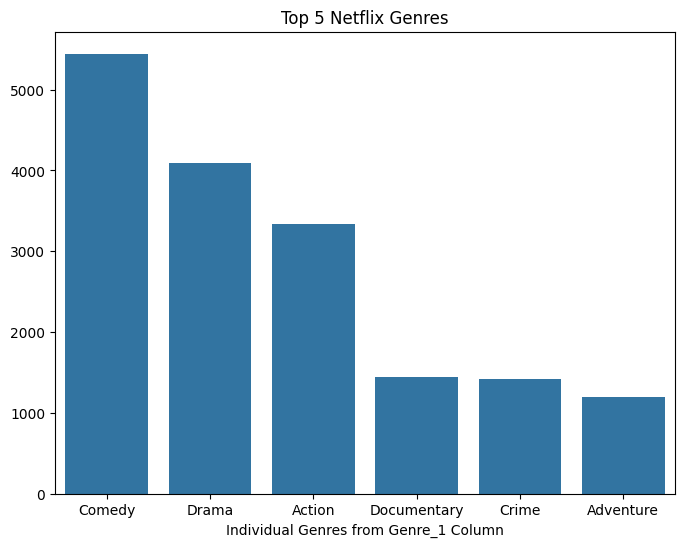

In [55]:
# Separate the Hulu rows from the rest of the df
netflix_tv = streaming_clean[streaming_clean["Service_Name"] == "Netflix"] 
# Group the Genre_1 column and get the total counts for each genre
netflix_tv_genres = netflix_tv.groupby("Genre_1")["Genre_1"].count().reset_index(name = "Count")
# Ascertain the top 5 genres
top_netflix_tv_genres = netflix_tv_genres.sort_values("Count", ascending = False).head(6)

plt.figure(figsize = (8, 6))
sn.barplot(x = top_netflix_tv_genres["Genre_1"], y = top_netflix_tv_genres["Count"])
plt.xlabel("Individual Genres from Genre_1 Column")
plt.ylabel(None)
plt.title("Top 5 Netflix Genres")

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

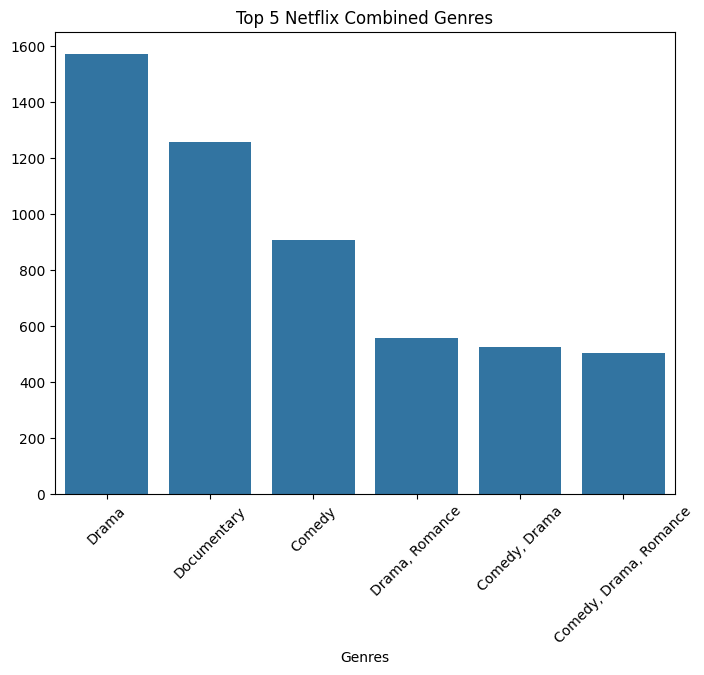

In [56]:
# Group the Genre_1 column and get the total counts for each genre
netflix_tv_genres = netflix_tv.groupby("Combined_Genres")["Combined_Genres"].count().reset_index(name = "Count")
# Ascertain the top 5 genres
top_netflix_tv_genres = netflix_tv_genres.sort_values("Count", ascending = False).head(6)

plt.figure(figsize = (8, 6))
sn.barplot(x = top_apple_tv_genres["Combined_Genres"], y = top_apple_tv_genres["Count"])
plt.xlabel("Genres")
plt.ylabel(None)
plt.xticks(rotation = 45)
plt.title("Top 5 Netflix Combined Genres")


plt.show

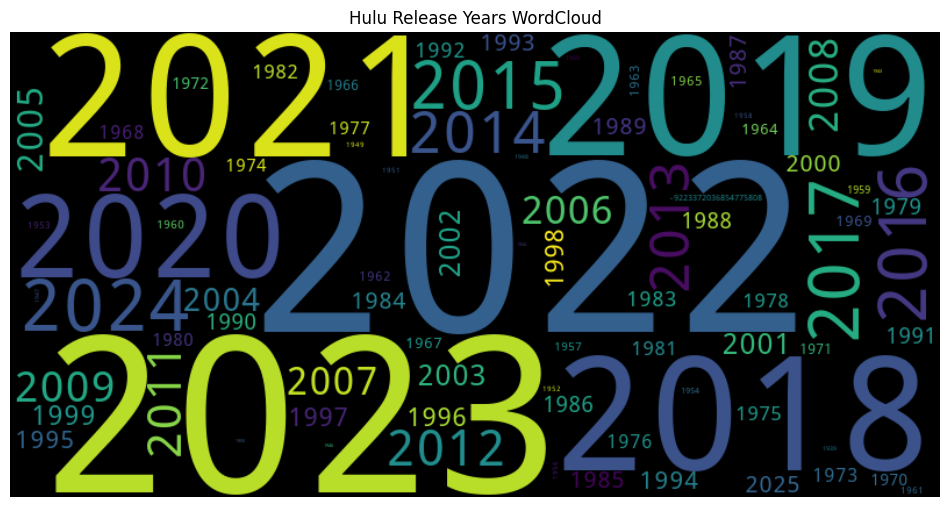

In [57]:
# Create variable with value counts of each release year
release_yr_cnts = hulu_tv["Release_Year"].value_counts()

# Convert the index of the Release Years from integers to strings because WordCloud requires strings inputs
release_yr_cnts.index = release_yr_cnts.index.map(str)

# Create the WordCloud specifying 
netflix_tv_wordcloud = WordCloud(width = 800, height = 400, background_color = "black").generate_from_frequencies(release_yr_cnts)

# Setting figure size in inches
plt.figure(figsize = (12, 8))
# Show the created WordCloud with a bilinear interpolation, which is used to estimate the value of pixels used to generate the image
plt.imshow(hulu_tv_wordcloud, interpolation = "bilinear")
# Do not display axes
plt.axis("off")
# Create a title for the WordCloud
plt.title("Hulu Release Years WordCloud")
# Show the plot
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

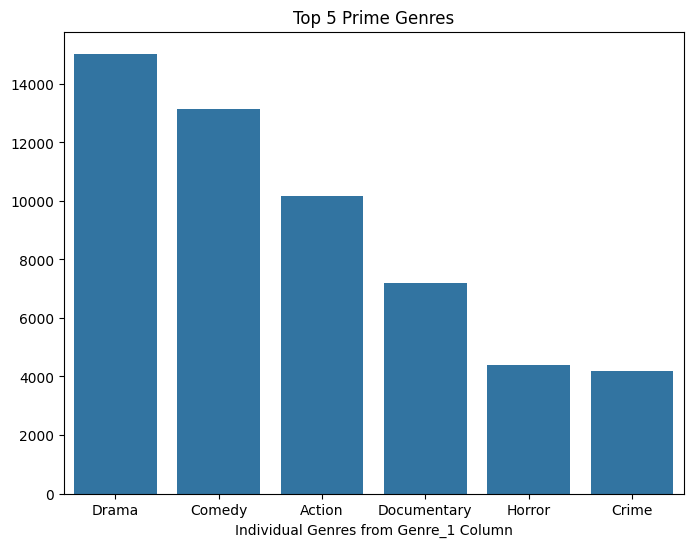

In [58]:
# Separate the Hulu rows from the rest of the df
prime_tv = streaming_clean[streaming_clean["Service_Name"] == "Prime"] 
# Group the Genre_1 column and get the total counts for each genre
prime_tv_genres = prime_tv.groupby("Genre_1")["Genre_1"].count().reset_index(name = "Count")
# Ascertain the top 5 genres
top_prime_tv_genres = prime_tv_genres.sort_values("Count", ascending = False).head(6)

plt.figure(figsize = (8, 6))
sn.barplot(x = top_prime_tv_genres["Genre_1"], y = top_prime_tv_genres["Count"])
plt.xlabel("Individual Genres from Genre_1 Column")
plt.ylabel(None)
plt.title("Top 5 Prime Genres")

plt.show

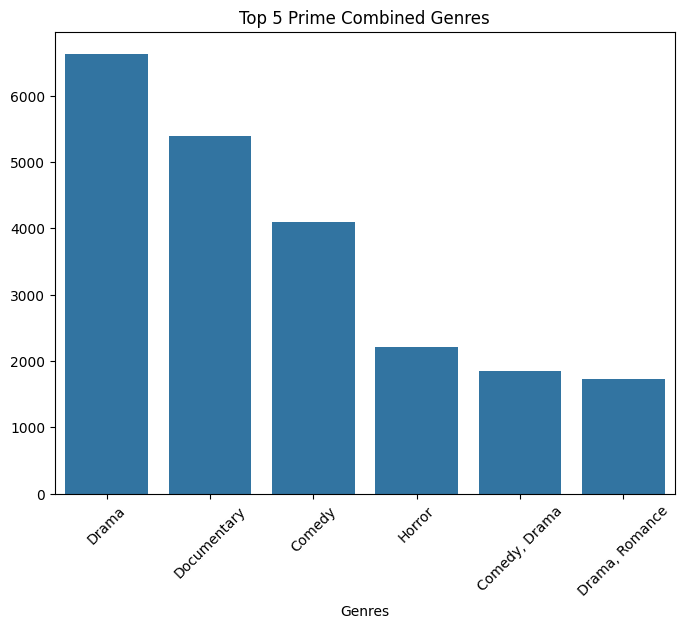

In [59]:
# Group the Genre_1 column and get the total counts for each genre
prime_tv_genres = prime_tv.groupby("Combined_Genres")["Combined_Genres"].count().reset_index(name = "Count")
# Ascertain the top 5 genres
top_prime_tv_genres = prime_tv_genres.sort_values("Count", ascending = False).head(6)

plt.figure(figsize = (8, 6))
sn.barplot(x = top_prime_tv_genres["Combined_Genres"], y = top_prime_tv_genres["Count"])
plt.xlabel("Genres")
plt.ylabel(None)
plt.xticks(rotation = 45)
plt.title("Top 5 Prime Combined Genres")

plt.show()

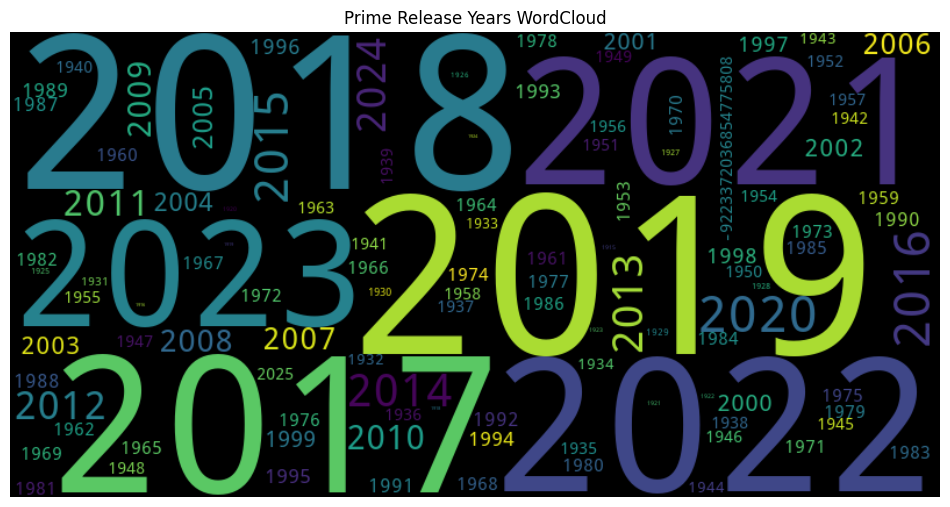

In [60]:
# Create variable with value counts of each release year
release_yr_cnts = prime_tv["Release_Year"].value_counts()

# Convert the index of the Release Years from integers to strings because WordCloud requires strings inputs
release_yr_cnts.index = release_yr_cnts.index.map(str)

# Create the WordCloud specifying 
prime_tv_wordcloud = WordCloud(width = 800, height = 400, background_color = "black").generate_from_frequencies(release_yr_cnts)

# Setting figure size in inches
plt.figure(figsize = (12, 8))
# Show the created WordCloud with a bilinear interpolation, which is used to estimate the value of pixels used to generate the image
plt.imshow(prime_tv_wordcloud, interpolation = "bilinear")
# Do not display axes
plt.axis("off")
# Create a title for the WordCloud
plt.title("Prime Release Years WordCloud")
# Show the plot
plt.show()